In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
import torch
from torch.utils.data import Dataset
import numpy as np
import os

df = pd.read_csv('dataset.csv')

# Handle class imbalance
df_majority = df[df.Genre == 'Drama']
df_minority = df[df.Genre != 'Drama']
df_majority_downsampled = resample(df_majority, replace=False, n_samples=200, random_state=42)
df_balanced = pd.concat([df_majority_downsampled, df_minority])
genre_counts = df_balanced['Genre'].value_counts()
df_filtered = df_balanced[df_balanced['Genre'].isin(genre_counts[genre_counts >= 10].index)]

class MovieDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased')
model = BertForSequenceClassification.from_pretrained('HooshvareLab/bert-fa-base-uncased', num_labels=len(genre_counts[genre_counts >= 10]))

# Encode labels
label_encoder = LabelEncoder()
df_filtered['Genre'] = label_encoder.fit_transform(df_filtered['Genre'])

# Define cross-validation
skf = StratifiedKFold(n_splits=5)

# Early Stopping callback
class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=3):
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = None
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, **kwargs):
        logs = kwargs['metrics']
        if self.best_loss is None or logs['eval_loss'] < self.best_loss:
            self.best_loss = logs['eval_loss']
            self.patience_counter = 0
        else:
            self.patience_counter += 1

        if self.patience_counter >= self.early_stopping_patience:
            print("Stopping early")
            control.should_training_stop = True

def train_and_evaluate(train_index, test_index, fold_num, device):
    train_df = df_filtered.iloc[train_index]
    test_df = df_filtered.iloc[test_index]

    train_dataset = MovieDataset(
        texts=train_df['Content_1'].tolist(),
        labels=train_df['Genre'].tolist(),
        tokenizer=tokenizer,
        max_len=128
    )

    test_dataset = MovieDataset(
        texts=test_df['Content_1'].tolist(),
        labels=test_df['Genre'].tolist(),
        tokenizer=tokenizer,
        max_len=128
    )

    # Define the training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/fold_{fold_num}',
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'./logs/fold_{fold_num}',
        logging_steps=10,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=5e-5,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to='none',
        no_cuda=False if torch.cuda.is_available() else True
    )

    # Create a Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train the model
    trainer.train()

    # Evaluate the model on the test set
    results = trainer.evaluate(test_dataset)

    # Predict on the test set
    predictions, labels, _ = trainer.predict(test_dataset)
    predictions = predictions.argmax(axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)

    # Calculate F1 score
    f1 = f1_score(labels, predictions, average='macro')

    print(f'Fold {fold_num} Accuracy: {accuracy:.4f}')
    print(f'Fold {fold_num} F1 Score: {f1:.4f}')
    print(classification_report(labels, predictions, target_names=label_encoder.classes_))

    return accuracy, f1

# Cross-validation loop
accuracies = []
f1_scores = []

# Assuming 4 GPUs
num_gpus = 4

for fold_num, (train_index, test_index) in enumerate(skf.split(df_filtered, df_filtered['Genre'])):
    device = f'cuda:{fold_num % num_gpus}' if torch.cuda.is_available() else 'cpu'
    os.environ["CUDA_VISIBLE_DEVICES"] = str(fold_num % num_gpus)
    
    accuracy, f1 = train_and_evaluate(train_index, test_index, fold_num, device)
    accuracies.append(accuracy)
    f1_scores.append(f1)

# Print overall results
print(f'Overall Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')
print(f'Overall F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/k8/xdc9g2pn7v561ty2fk116vjh0000gn/T/ipykernel_6271/317131113.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Genre'] = label_encoder.fit_transform(df_filtered['Genre'])
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnin

{'loss': 2.4798, 'grad_norm': 8.154491424560547, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.24}


  5%|▍         | 20/420 [00:37<12:15,  1.84s/it]

{'loss': 2.4076, 'grad_norm': 9.875574111938477, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.48}


  7%|▋         | 30/420 [00:55<11:49,  1.82s/it]

{'loss': 2.3475, 'grad_norm': 8.27158260345459, 'learning_rate': 3e-06, 'epoch': 0.71}


 10%|▉         | 40/420 [01:13<11:37,  1.83s/it]

{'loss': 2.2264, 'grad_norm': 9.25333023071289, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.95}


 10%|█         | 42/420 [01:21<11:26,  1.82s/it]

{'eval_loss': 2.214942216873169, 'eval_runtime': 4.5468, 'eval_samples_per_second': 36.949, 'eval_steps_per_second': 2.419, 'epoch': 1.0}


 12%|█▏        | 50/420 [01:38<12:26,  2.02s/it]

{'loss': 2.1336, 'grad_norm': 7.887829303741455, 'learning_rate': 5e-06, 'epoch': 1.19}


 14%|█▍        | 60/420 [01:56<11:02,  1.84s/it]

{'loss': 2.0291, 'grad_norm': 6.855902194976807, 'learning_rate': 6e-06, 'epoch': 1.43}


 17%|█▋        | 70/420 [02:14<10:35,  1.82s/it]

{'loss': 1.9442, 'grad_norm': 6.059995174407959, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.67}


 19%|█▉        | 80/420 [02:33<10:12,  1.80s/it]

{'loss': 2.0672, 'grad_norm': 6.146152019500732, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.9}


 20%|██        | 84/420 [02:44<10:00,  1.79s/it]

{'eval_loss': 2.004823923110962, 'eval_runtime': 4.4581, 'eval_samples_per_second': 37.685, 'eval_steps_per_second': 2.467, 'epoch': 2.0}


 21%|██▏       | 90/420 [02:56<11:29,  2.09s/it]

{'loss': 1.9361, 'grad_norm': 6.057654857635498, 'learning_rate': 9e-06, 'epoch': 2.14}


 24%|██▍       | 100/420 [03:14<09:44,  1.83s/it]

{'loss': 1.8161, 'grad_norm': 5.955370903015137, 'learning_rate': 1e-05, 'epoch': 2.38}


 26%|██▌       | 110/420 [03:32<09:19,  1.80s/it]

{'loss': 1.7937, 'grad_norm': 5.314672946929932, 'learning_rate': 1.1000000000000001e-05, 'epoch': 2.62}


 29%|██▊       | 120/420 [03:50<09:01,  1.80s/it]

{'loss': 1.9645, 'grad_norm': 7.6002020835876465, 'learning_rate': 1.2e-05, 'epoch': 2.86}


 30%|███       | 126/420 [04:06<08:42,  1.78s/it]

{'eval_loss': 2.0489799976348877, 'eval_runtime': 4.4513, 'eval_samples_per_second': 37.742, 'eval_steps_per_second': 2.471, 'epoch': 3.0}


 31%|███       | 130/420 [04:14<11:34,  2.39s/it]

{'loss': 1.8888, 'grad_norm': 6.730014801025391, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.1}


 33%|███▎      | 140/420 [04:32<08:33,  1.83s/it]

{'loss': 1.7554, 'grad_norm': 6.691455841064453, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.33}


 36%|███▌      | 150/420 [04:50<08:10,  1.82s/it]

{'loss': 1.898, 'grad_norm': 8.848814010620117, 'learning_rate': 1.5e-05, 'epoch': 3.57}


 38%|███▊      | 160/420 [05:09<07:48,  1.80s/it]

{'loss': 1.7452, 'grad_norm': 7.0325117111206055, 'learning_rate': 1.6000000000000003e-05, 'epoch': 3.81}


 40%|████      | 168/420 [05:27<07:28,  1.78s/it]

{'eval_loss': 1.9890002012252808, 'eval_runtime': 4.4532, 'eval_samples_per_second': 37.725, 'eval_steps_per_second': 2.47, 'epoch': 4.0}


 40%|████      | 170/420 [05:32<12:25,  2.98s/it]

{'loss': 1.6958, 'grad_norm': 10.690324783325195, 'learning_rate': 1.7000000000000003e-05, 'epoch': 4.05}


 43%|████▎     | 180/420 [05:50<07:25,  1.85s/it]

{'loss': 1.5503, 'grad_norm': 6.453670024871826, 'learning_rate': 1.8e-05, 'epoch': 4.29}


 45%|████▌     | 190/420 [06:08<06:55,  1.81s/it]

{'loss': 1.5777, 'grad_norm': 8.7909574508667, 'learning_rate': 1.9e-05, 'epoch': 4.52}


 48%|████▊     | 200/420 [06:26<06:36,  1.80s/it]

{'loss': 1.6047, 'grad_norm': 7.619956016540527, 'learning_rate': 2e-05, 'epoch': 4.76}


 50%|█████     | 210/420 [06:44<06:15,  1.79s/it]

{'loss': 1.604, 'grad_norm': 9.639723777770996, 'learning_rate': 2.1e-05, 'epoch': 5.0}



 50%|█████     | 210/420 [06:49<06:15,  1.79s/it]

{'eval_loss': 2.0035457611083984, 'eval_runtime': 4.4482, 'eval_samples_per_second': 37.768, 'eval_steps_per_second': 2.473, 'epoch': 5.0}


 52%|█████▏    | 220/420 [07:08<06:08,  1.84s/it]

{'loss': 1.3032, 'grad_norm': 6.409624099731445, 'learning_rate': 2.2000000000000003e-05, 'epoch': 5.24}


 55%|█████▍    | 230/420 [07:26<05:43,  1.81s/it]

{'loss': 1.4033, 'grad_norm': 14.291940689086914, 'learning_rate': 2.3000000000000003e-05, 'epoch': 5.48}


 57%|█████▋    | 240/420 [07:44<05:25,  1.81s/it]

{'loss': 1.3546, 'grad_norm': 8.347304344177246, 'learning_rate': 2.4e-05, 'epoch': 5.71}


 60%|█████▉    | 250/420 [08:02<05:06,  1.80s/it]

{'loss': 1.2451, 'grad_norm': 10.455099105834961, 'learning_rate': 2.5e-05, 'epoch': 5.95}


 60%|██████    | 252/420 [08:10<04:58,  1.78s/it]

{'eval_loss': 1.989188551902771, 'eval_runtime': 4.4369, 'eval_samples_per_second': 37.865, 'eval_steps_per_second': 2.479, 'epoch': 6.0}


 62%|██████▏   | 260/420 [08:26<05:11,  1.95s/it]

{'loss': 1.1007, 'grad_norm': 6.586605072021484, 'learning_rate': 2.6000000000000002e-05, 'epoch': 6.19}


 64%|██████▍   | 270/420 [08:44<04:32,  1.81s/it]

{'loss': 1.0584, 'grad_norm': 6.1191582679748535, 'learning_rate': 2.7000000000000002e-05, 'epoch': 6.43}


 67%|██████▋   | 280/420 [09:02<04:12,  1.80s/it]

{'loss': 1.1321, 'grad_norm': 4.521974563598633, 'learning_rate': 2.8000000000000003e-05, 'epoch': 6.67}


 69%|██████▉   | 290/420 [09:20<03:56,  1.82s/it]

{'loss': 1.0611, 'grad_norm': 5.61923360824585, 'learning_rate': 2.9e-05, 'epoch': 6.9}


 70%|███████   | 294/420 [09:32<03:45,  1.79s/it]

{'eval_loss': 2.239558458328247, 'eval_runtime': 4.4907, 'eval_samples_per_second': 37.411, 'eval_steps_per_second': 2.45, 'epoch': 7.0}
Stopping early


 70%|███████   | 294/420 [09:33<04:05,  1.95s/it]


{'train_runtime': 573.939, 'train_samples_per_second': 11.691, 'train_steps_per_second': 0.732, 'train_loss': 1.7212261294021087, 'epoch': 7.0}


100%|██████████| 11/11 [00:04<00:00,  2.74it/s]


Stopping early


100%|██████████| 11/11 [00:04<00:00,  2.74it/s]
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Fold 0 Accuracy: 0.3512
Fold 0 F1 Score: 0.0677
                          precision    recall  f1-score   support

                  Action       0.00      0.00      0.00        15
               Adventure       0.00      0.00      0.00        10
       Arts & Literature       0.00      0.00      0.00         7
                  Comedy       0.38      0.91      0.53        53
                   Crime       0.00      0.00      0.00        14
    Culture & Traditions       0.00      0.00      0.00         5
                   Drama       0.28      0.28      0.28        40
                  Family       0.00      0.00      0.00         5
                 History       0.00      0.00      0.00         3
Human Interest & Society       0.00      0.00      0.00         9
                 Romance       0.00      0.00      0.00         3
                     War       0.00      0.00      0.00         4

                accuracy                           0.35       168
               macro avg  

  2%|▏         | 10/420 [00:17<12:12,  1.79s/it]

{'loss': 1.7328, 'grad_norm': 6.504175186157227, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.24}


  5%|▍         | 20/420 [00:35<11:54,  1.79s/it]

{'loss': 1.7529, 'grad_norm': 7.223525047302246, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.48}


  7%|▋         | 30/420 [00:53<11:41,  1.80s/it]

{'loss': 1.6876, 'grad_norm': 8.411275863647461, 'learning_rate': 3e-06, 'epoch': 0.71}


 10%|▉         | 40/420 [01:12<11:52,  1.88s/it]

{'loss': 1.5392, 'grad_norm': 6.6965227127075195, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.95}


 10%|█         | 42/420 [01:20<11:23,  1.81s/it]

{'eval_loss': 1.6503522396087646, 'eval_runtime': 4.4152, 'eval_samples_per_second': 38.051, 'eval_steps_per_second': 2.491, 'epoch': 1.0}


 12%|█▏        | 50/420 [01:36<12:14,  1.98s/it]

{'loss': 1.6663, 'grad_norm': 9.182774543762207, 'learning_rate': 5e-06, 'epoch': 1.19}


 14%|█▍        | 60/420 [01:54<11:03,  1.84s/it]

{'loss': 1.6341, 'grad_norm': 7.076425075531006, 'learning_rate': 6e-06, 'epoch': 1.43}


 17%|█▋        | 70/420 [02:12<10:43,  1.84s/it]

{'loss': 1.5741, 'grad_norm': 6.26603364944458, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.67}


 19%|█▉        | 80/420 [02:31<10:27,  1.85s/it]

{'loss': 1.6368, 'grad_norm': 6.874195575714111, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.9}


 20%|██        | 84/420 [02:43<10:11,  1.82s/it]

{'eval_loss': 1.6440038681030273, 'eval_runtime': 4.7322, 'eval_samples_per_second': 35.501, 'eval_steps_per_second': 2.324, 'epoch': 2.0}


 21%|██▏       | 90/420 [02:55<11:40,  2.12s/it]

{'loss': 1.545, 'grad_norm': 6.44730806350708, 'learning_rate': 9e-06, 'epoch': 2.14}


 24%|██▍       | 100/420 [03:13<09:52,  1.85s/it]

{'loss': 1.5153, 'grad_norm': 6.326126575469971, 'learning_rate': 1e-05, 'epoch': 2.38}


 26%|██▌       | 110/420 [03:32<09:29,  1.84s/it]

{'loss': 1.4726, 'grad_norm': 7.79194450378418, 'learning_rate': 1.1000000000000001e-05, 'epoch': 2.62}


 29%|██▊       | 120/420 [03:50<09:10,  1.84s/it]

{'loss': 1.4569, 'grad_norm': 6.125738143920898, 'learning_rate': 1.2e-05, 'epoch': 2.86}


 30%|███       | 126/420 [04:06<08:52,  1.81s/it]

{'eval_loss': 1.6038527488708496, 'eval_runtime': 4.7458, 'eval_samples_per_second': 35.4, 'eval_steps_per_second': 2.318, 'epoch': 3.0}


 31%|███       | 130/420 [04:15<11:52,  2.46s/it]

{'loss': 1.3102, 'grad_norm': 8.34884262084961, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.1}


 33%|███▎      | 140/420 [04:33<08:45,  1.88s/it]

{'loss': 1.235, 'grad_norm': 8.017032623291016, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.33}


 36%|███▌      | 150/420 [04:52<08:21,  1.86s/it]

{'loss': 1.4249, 'grad_norm': 6.642542362213135, 'learning_rate': 1.5e-05, 'epoch': 3.57}


 38%|███▊      | 160/420 [05:10<08:00,  1.85s/it]

{'loss': 1.2439, 'grad_norm': 8.155868530273438, 'learning_rate': 1.6000000000000003e-05, 'epoch': 3.81}


 40%|████      | 168/420 [05:29<07:38,  1.82s/it]

{'eval_loss': 1.5664305686950684, 'eval_runtime': 4.7258, 'eval_samples_per_second': 35.549, 'eval_steps_per_second': 2.328, 'epoch': 4.0}


 40%|████      | 170/420 [05:34<12:47,  3.07s/it]

{'loss': 1.4769, 'grad_norm': 10.680486679077148, 'learning_rate': 1.7000000000000003e-05, 'epoch': 4.05}


 43%|████▎     | 180/420 [05:53<07:32,  1.89s/it]

{'loss': 1.1781, 'grad_norm': 8.925761222839355, 'learning_rate': 1.8e-05, 'epoch': 4.29}


 45%|████▌     | 190/420 [06:11<07:04,  1.84s/it]

{'loss': 1.0795, 'grad_norm': 7.337277889251709, 'learning_rate': 1.9e-05, 'epoch': 4.52}


 48%|████▊     | 200/420 [06:30<06:45,  1.84s/it]

{'loss': 1.1386, 'grad_norm': 13.931605339050293, 'learning_rate': 2e-05, 'epoch': 4.76}


 50%|█████     | 210/420 [06:48<06:25,  1.83s/it]

{'loss': 1.1632, 'grad_norm': 8.120596885681152, 'learning_rate': 2.1e-05, 'epoch': 5.0}



 50%|█████     | 210/420 [06:53<06:25,  1.83s/it]

{'eval_loss': 1.5452929735183716, 'eval_runtime': 4.7022, 'eval_samples_per_second': 35.728, 'eval_steps_per_second': 2.339, 'epoch': 5.0}


 52%|█████▏    | 220/420 [07:12<06:24,  1.92s/it]

{'loss': 1.0093, 'grad_norm': 6.056740760803223, 'learning_rate': 2.2000000000000003e-05, 'epoch': 5.24}


 55%|█████▍    | 230/420 [07:31<05:52,  1.85s/it]

{'loss': 0.9922, 'grad_norm': 7.189308166503906, 'learning_rate': 2.3000000000000003e-05, 'epoch': 5.48}


 57%|█████▋    | 240/420 [07:49<05:33,  1.85s/it]

{'loss': 0.964, 'grad_norm': 6.460126876831055, 'learning_rate': 2.4e-05, 'epoch': 5.71}


 60%|█████▉    | 250/420 [08:08<05:14,  1.85s/it]

{'loss': 0.849, 'grad_norm': 16.911874771118164, 'learning_rate': 2.5e-05, 'epoch': 5.95}


 60%|██████    | 252/420 [08:16<05:07,  1.83s/it]

{'eval_loss': 1.6612448692321777, 'eval_runtime': 4.6681, 'eval_samples_per_second': 35.989, 'eval_steps_per_second': 2.356, 'epoch': 6.0}


 62%|██████▏   | 260/420 [08:32<05:20,  2.00s/it]

{'loss': 0.9143, 'grad_norm': 9.816947937011719, 'learning_rate': 2.6000000000000002e-05, 'epoch': 6.19}


 64%|██████▍   | 270/420 [08:51<04:39,  1.87s/it]

{'loss': 0.9012, 'grad_norm': 6.449217796325684, 'learning_rate': 2.7000000000000002e-05, 'epoch': 6.43}


 67%|██████▋   | 280/420 [09:09<04:19,  1.85s/it]

{'loss': 0.8247, 'grad_norm': 8.56834602355957, 'learning_rate': 2.8000000000000003e-05, 'epoch': 6.67}


 69%|██████▉   | 290/420 [09:28<04:00,  1.85s/it]

{'loss': 0.8055, 'grad_norm': 6.552677631378174, 'learning_rate': 2.9e-05, 'epoch': 6.9}


 70%|███████   | 294/420 [09:40<03:51,  1.84s/it]

{'eval_loss': 1.8146791458129883, 'eval_runtime': 4.7466, 'eval_samples_per_second': 35.394, 'eval_steps_per_second': 2.317, 'epoch': 7.0}


 71%|███████▏  | 300/420 [09:52<04:17,  2.15s/it]

{'loss': 0.844, 'grad_norm': 6.374269008636475, 'learning_rate': 3e-05, 'epoch': 7.14}


 74%|███████▍  | 310/420 [10:11<03:23,  1.85s/it]

{'loss': 0.7055, 'grad_norm': 4.218990325927734, 'learning_rate': 3.1e-05, 'epoch': 7.38}


 76%|███████▌  | 320/420 [10:29<03:03,  1.84s/it]

{'loss': 0.8441, 'grad_norm': 11.234764099121094, 'learning_rate': 3.2000000000000005e-05, 'epoch': 7.62}


 79%|███████▊  | 330/420 [10:47<02:46,  1.85s/it]

{'loss': 0.7025, 'grad_norm': 5.620327949523926, 'learning_rate': 3.3e-05, 'epoch': 7.86}


 80%|████████  | 336/420 [11:03<02:33,  1.83s/it]

{'eval_loss': 1.6662927865982056, 'eval_runtime': 4.7349, 'eval_samples_per_second': 35.481, 'eval_steps_per_second': 2.323, 'epoch': 8.0}
Stopping early


 80%|████████  | 336/420 [11:05<02:46,  1.98s/it]


{'train_runtime': 665.7419, 'train_samples_per_second': 10.079, 'train_steps_per_second': 0.631, 'train_loss': 1.2269158576216017, 'epoch': 8.0}


100%|██████████| 11/11 [00:04<00:00,  2.58it/s]


Stopping early


100%|██████████| 11/11 [00:04<00:00,  2.54it/s]
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Fold 1 Accuracy: 0.4583
Fold 1 F1 Score: 0.2039
                          precision    recall  f1-score   support

                  Action       0.64      0.47      0.54        15
               Adventure       0.00      0.00      0.00        10
       Arts & Literature       0.00      0.00      0.00         7
                  Comedy       0.63      0.72      0.67        53
                   Crime       0.50      0.36      0.42        14
    Culture & Traditions       0.00      0.00      0.00         5
                   Drama       0.75      0.45      0.56        40
                  Family       0.00      0.00      0.00         5
                 History       0.00      0.00      0.00         3
Human Interest & Society       0.15      1.00      0.26         9
                 Romance       0.00      0.00      0.00         3
                     War       0.00      0.00      0.00         4

                accuracy                           0.46       168
               macro avg  

  2%|▏         | 10/420 [00:18<12:36,  1.85s/it]

{'loss': 1.1976, 'grad_norm': 5.596986770629883, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.24}


  5%|▍         | 20/420 [00:36<12:15,  1.84s/it]

{'loss': 1.0674, 'grad_norm': 8.037359237670898, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.48}


  7%|▋         | 30/420 [00:55<11:55,  1.83s/it]

{'loss': 0.955, 'grad_norm': 11.504555702209473, 'learning_rate': 3e-06, 'epoch': 0.71}


 10%|▉         | 40/420 [01:13<11:35,  1.83s/it]

{'loss': 1.1326, 'grad_norm': 7.122539520263672, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.95}


 10%|█         | 42/420 [01:21<11:22,  1.81s/it]

{'eval_loss': 1.0727286338806152, 'eval_runtime': 4.6869, 'eval_samples_per_second': 35.845, 'eval_steps_per_second': 2.347, 'epoch': 1.0}


 12%|█▏        | 50/420 [01:37<12:18,  2.00s/it]

{'loss': 1.0988, 'grad_norm': 9.800680160522461, 'learning_rate': 5e-06, 'epoch': 1.19}


 14%|█▍        | 60/420 [01:56<11:05,  1.85s/it]

{'loss': 1.0404, 'grad_norm': 9.502842903137207, 'learning_rate': 6e-06, 'epoch': 1.43}


 17%|█▋        | 70/420 [02:14<10:49,  1.85s/it]

{'loss': 0.8504, 'grad_norm': 6.831904888153076, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.67}


 19%|█▉        | 80/420 [02:33<10:32,  1.86s/it]

{'loss': 1.1199, 'grad_norm': 5.5928778648376465, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.9}


 20%|██        | 84/420 [02:45<10:13,  1.82s/it]

{'eval_loss': 1.0574764013290405, 'eval_runtime': 4.6816, 'eval_samples_per_second': 35.885, 'eval_steps_per_second': 2.35, 'epoch': 2.0}


 21%|██▏       | 90/420 [02:57<11:45,  2.14s/it]

{'loss': 0.9818, 'grad_norm': 8.596301078796387, 'learning_rate': 9e-06, 'epoch': 2.14}


 24%|██▍       | 100/420 [03:15<09:53,  1.86s/it]

{'loss': 0.9046, 'grad_norm': 8.017802238464355, 'learning_rate': 1e-05, 'epoch': 2.38}


 26%|██▌       | 110/420 [03:34<09:32,  1.85s/it]

{'loss': 0.9858, 'grad_norm': 7.113959789276123, 'learning_rate': 1.1000000000000001e-05, 'epoch': 2.62}


 29%|██▊       | 120/420 [03:52<09:14,  1.85s/it]

{'loss': 0.8976, 'grad_norm': 7.037806034088135, 'learning_rate': 1.2e-05, 'epoch': 2.86}


 30%|███       | 126/420 [04:08<08:54,  1.82s/it]

{'eval_loss': 0.9953364133834839, 'eval_runtime': 4.6672, 'eval_samples_per_second': 35.996, 'eval_steps_per_second': 2.357, 'epoch': 3.0}


 31%|███       | 130/420 [04:17<11:53,  2.46s/it]

{'loss': 0.8023, 'grad_norm': 3.2308483123779297, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.1}


 33%|███▎      | 140/420 [04:35<08:43,  1.87s/it]

{'loss': 0.8302, 'grad_norm': 8.113643646240234, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.33}


 36%|███▌      | 150/420 [04:54<08:17,  1.84s/it]

{'loss': 0.8952, 'grad_norm': 8.28604507446289, 'learning_rate': 1.5e-05, 'epoch': 3.57}


 38%|███▊      | 160/420 [05:12<08:02,  1.86s/it]

{'loss': 0.7496, 'grad_norm': 8.259178161621094, 'learning_rate': 1.6000000000000003e-05, 'epoch': 3.81}


 40%|████      | 168/420 [05:32<07:38,  1.82s/it]

{'eval_loss': 0.9977231621742249, 'eval_runtime': 4.663, 'eval_samples_per_second': 36.029, 'eval_steps_per_second': 2.359, 'epoch': 4.0}


 40%|████      | 170/420 [05:36<12:43,  3.06s/it]

{'loss': 0.891, 'grad_norm': 6.991774559020996, 'learning_rate': 1.7000000000000003e-05, 'epoch': 4.05}


 43%|████▎     | 180/420 [05:55<07:31,  1.88s/it]

{'loss': 0.7165, 'grad_norm': 6.362575531005859, 'learning_rate': 1.8e-05, 'epoch': 4.29}


 45%|████▌     | 190/420 [06:13<07:04,  1.85s/it]

{'loss': 0.7775, 'grad_norm': 5.305840492248535, 'learning_rate': 1.9e-05, 'epoch': 4.52}


 48%|████▊     | 200/420 [06:34<07:52,  2.15s/it]

{'loss': 0.6939, 'grad_norm': 6.503593921661377, 'learning_rate': 2e-05, 'epoch': 4.76}


 50%|█████     | 210/420 [06:56<07:42,  2.20s/it]

{'loss': 0.8502, 'grad_norm': 9.445626258850098, 'learning_rate': 2.1e-05, 'epoch': 5.0}



 50%|█████     | 210/420 [07:01<07:42,  2.20s/it]

{'eval_loss': 1.0592536926269531, 'eval_runtime': 5.2932, 'eval_samples_per_second': 31.739, 'eval_steps_per_second': 2.078, 'epoch': 5.0}


 52%|█████▏    | 220/420 [07:25<07:44,  2.32s/it]

{'loss': 0.5662, 'grad_norm': 3.62245774269104, 'learning_rate': 2.2000000000000003e-05, 'epoch': 5.24}


 55%|█████▍    | 230/420 [07:48<07:04,  2.23s/it]

{'loss': 0.781, 'grad_norm': 6.686427593231201, 'learning_rate': 2.3000000000000003e-05, 'epoch': 5.48}


 57%|█████▋    | 240/420 [08:10<06:42,  2.24s/it]

{'loss': 0.7527, 'grad_norm': 4.466129779815674, 'learning_rate': 2.4e-05, 'epoch': 5.71}


 60%|█████▉    | 250/420 [08:33<06:21,  2.25s/it]

{'loss': 0.7206, 'grad_norm': 5.8240203857421875, 'learning_rate': 2.5e-05, 'epoch': 5.95}


 60%|██████    | 252/420 [08:42<06:11,  2.21s/it]

{'eval_loss': 0.9644047021865845, 'eval_runtime': 5.326, 'eval_samples_per_second': 31.543, 'eval_steps_per_second': 2.065, 'epoch': 6.0}


 62%|██████▏   | 260/420 [09:02<06:27,  2.42s/it]

{'loss': 0.7162, 'grad_norm': 4.9986724853515625, 'learning_rate': 2.6000000000000002e-05, 'epoch': 6.19}


 64%|██████▍   | 270/420 [09:24<05:38,  2.25s/it]

{'loss': 0.5835, 'grad_norm': 3.9984805583953857, 'learning_rate': 2.7000000000000002e-05, 'epoch': 6.43}


 67%|██████▋   | 280/420 [09:47<05:13,  2.24s/it]

{'loss': 0.609, 'grad_norm': 12.335217475891113, 'learning_rate': 2.8000000000000003e-05, 'epoch': 6.67}


 69%|██████▉   | 290/420 [10:09<04:52,  2.25s/it]

{'loss': 0.68, 'grad_norm': 2.605898141860962, 'learning_rate': 2.9e-05, 'epoch': 6.9}


 70%|███████   | 294/420 [10:24<04:37,  2.20s/it]

{'eval_loss': 1.011953592300415, 'eval_runtime': 5.3242, 'eval_samples_per_second': 31.554, 'eval_steps_per_second': 2.066, 'epoch': 7.0}


 71%|███████▏  | 300/420 [10:39<05:11,  2.59s/it]

{'loss': 0.7605, 'grad_norm': 4.3256096839904785, 'learning_rate': 3e-05, 'epoch': 7.14}


 74%|███████▍  | 310/420 [11:01<04:08,  2.26s/it]

{'loss': 0.6059, 'grad_norm': 3.5395145416259766, 'learning_rate': 3.1e-05, 'epoch': 7.38}


 76%|███████▌  | 320/420 [11:24<03:44,  2.24s/it]

{'loss': 0.5883, 'grad_norm': 8.380646705627441, 'learning_rate': 3.2000000000000005e-05, 'epoch': 7.62}


 79%|███████▊  | 330/420 [11:46<03:21,  2.24s/it]

{'loss': 0.5824, 'grad_norm': 3.6188344955444336, 'learning_rate': 3.3e-05, 'epoch': 7.86}


 80%|████████  | 336/420 [12:05<03:05,  2.21s/it]

{'eval_loss': 1.0199178457260132, 'eval_runtime': 5.3534, 'eval_samples_per_second': 31.382, 'eval_steps_per_second': 2.055, 'epoch': 8.0}


 81%|████████  | 340/420 [12:16<03:57,  2.97s/it]

{'loss': 0.7583, 'grad_norm': 3.5420589447021484, 'learning_rate': 3.4000000000000007e-05, 'epoch': 8.1}


 83%|████████▎ | 350/420 [12:38<02:37,  2.25s/it]

{'loss': 0.5398, 'grad_norm': 6.1732072830200195, 'learning_rate': 3.5e-05, 'epoch': 8.33}


 86%|████████▌ | 360/420 [13:00<02:14,  2.24s/it]

{'loss': 0.7444, 'grad_norm': 4.453066825866699, 'learning_rate': 3.6e-05, 'epoch': 8.57}


 88%|████████▊ | 370/420 [13:23<01:52,  2.25s/it]

{'loss': 0.4783, 'grad_norm': 2.2480573654174805, 'learning_rate': 3.7e-05, 'epoch': 8.81}


 90%|█████████ | 378/420 [13:46<01:32,  2.21s/it]

{'eval_loss': 0.9505270719528198, 'eval_runtime': 5.353, 'eval_samples_per_second': 31.384, 'eval_steps_per_second': 2.055, 'epoch': 9.0}


 90%|█████████ | 380/420 [13:52<02:28,  3.72s/it]

{'loss': 0.5349, 'grad_norm': 2.4057304859161377, 'learning_rate': 3.8e-05, 'epoch': 9.05}


 93%|█████████▎| 390/420 [14:15<01:08,  2.29s/it]

{'loss': 0.6523, 'grad_norm': 2.7398874759674072, 'learning_rate': 3.9000000000000006e-05, 'epoch': 9.29}


 95%|█████████▌| 400/420 [14:37<00:45,  2.26s/it]

{'loss': 0.5966, 'grad_norm': 4.099208354949951, 'learning_rate': 4e-05, 'epoch': 9.52}


 98%|█████████▊| 410/420 [15:00<00:22,  2.24s/it]

{'loss': 0.6125, 'grad_norm': 4.047619819641113, 'learning_rate': 4.1e-05, 'epoch': 9.76}


100%|██████████| 420/420 [15:22<00:00,  2.22s/it]

{'loss': 0.5798, 'grad_norm': 24.350055694580078, 'learning_rate': 4.2e-05, 'epoch': 10.0}



100%|██████████| 420/420 [15:29<00:00,  2.22s/it]

{'eval_loss': 1.0112890005111694, 'eval_runtime': 5.4154, 'eval_samples_per_second': 31.023, 'eval_steps_per_second': 2.031, 'epoch': 10.0}


100%|██████████| 420/420 [15:31<00:00,  2.22s/it]


{'train_runtime': 931.6418, 'train_samples_per_second': 7.202, 'train_steps_per_second': 0.451, 'train_loss': 0.782891895657494, 'epoch': 10.0}


100%|██████████| 11/11 [00:04<00:00,  2.30it/s]
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Fold 2 Accuracy: 0.7083
Fold 2 F1 Score: 0.5013
                          precision    recall  f1-score   support

                  Action       1.00      0.87      0.93        15
               Adventure       1.00      0.50      0.67        10
       Arts & Literature       0.00      0.00      0.00         7
                  Comedy       0.54      1.00      0.70        53
                   Crime       0.82      0.69      0.75        13
    Culture & Traditions       0.00      0.00      0.00         5
                   Drama       1.00      0.75      0.86        40
                  Family       1.00      0.80      0.89         5
                 History       0.50      0.25      0.33         4
Human Interest & Society       0.00      0.00      0.00        10
                 Romance       0.00      0.00      0.00         2
                     War       0.80      1.00      0.89         4

                accuracy                           0.71       168
               macro avg  

  2%|▏         | 10/420 [00:22<15:11,  2.22s/it]

{'loss': 0.7757, 'grad_norm': 3.7065844535827637, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.24}


  5%|▍         | 20/420 [00:44<14:48,  2.22s/it]

{'loss': 0.683, 'grad_norm': 3.5400047302246094, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.48}


  7%|▋         | 30/420 [01:06<14:24,  2.22s/it]

{'loss': 0.579, 'grad_norm': 20.380332946777344, 'learning_rate': 3e-06, 'epoch': 0.71}


 10%|▉         | 40/420 [01:28<13:52,  2.19s/it]

{'loss': 0.635, 'grad_norm': 3.181504726409912, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.95}


 10%|█         | 42/420 [01:38<13:38,  2.17s/it]

{'eval_loss': 0.6168863773345947, 'eval_runtime': 5.3485, 'eval_samples_per_second': 31.411, 'eval_steps_per_second': 2.057, 'epoch': 1.0}


 12%|█▏        | 50/420 [01:58<14:50,  2.41s/it]

{'loss': 0.6557, 'grad_norm': 3.5124361515045166, 'learning_rate': 5e-06, 'epoch': 1.19}


 14%|█▍        | 60/420 [02:20<13:24,  2.23s/it]

{'loss': 0.7059, 'grad_norm': 5.4030561447143555, 'learning_rate': 6e-06, 'epoch': 1.43}


 17%|█▋        | 70/420 [02:42<13:00,  2.23s/it]

{'loss': 0.6224, 'grad_norm': 2.2063920497894287, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.67}


 19%|█▉        | 80/420 [03:05<12:37,  2.23s/it]

{'loss': 0.6265, 'grad_norm': 3.824903726577759, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.9}


 20%|██        | 84/420 [03:19<12:18,  2.20s/it]

{'eval_loss': 0.6120970845222473, 'eval_runtime': 5.3656, 'eval_samples_per_second': 31.311, 'eval_steps_per_second': 2.05, 'epoch': 2.0}


 21%|██▏       | 90/420 [03:34<14:19,  2.60s/it]

{'loss': 0.5813, 'grad_norm': 1.978850245475769, 'learning_rate': 9e-06, 'epoch': 2.14}


 24%|██▍       | 100/420 [03:57<12:02,  2.26s/it]

{'loss': 0.6969, 'grad_norm': 2.749202251434326, 'learning_rate': 1e-05, 'epoch': 2.38}


 26%|██▌       | 110/420 [04:19<11:34,  2.24s/it]

{'loss': 0.6376, 'grad_norm': 2.875206232070923, 'learning_rate': 1.1000000000000001e-05, 'epoch': 2.62}


 29%|██▊       | 120/420 [04:41<11:15,  2.25s/it]

{'loss': 0.5688, 'grad_norm': 2.1294326782226562, 'learning_rate': 1.2e-05, 'epoch': 2.86}


 30%|███       | 126/420 [05:00<10:48,  2.21s/it]

{'eval_loss': 0.615329384803772, 'eval_runtime': 5.3879, 'eval_samples_per_second': 31.181, 'eval_steps_per_second': 2.042, 'epoch': 3.0}


 31%|███       | 130/420 [05:11<14:19,  2.96s/it]

{'loss': 0.6304, 'grad_norm': 3.501085042953491, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.1}


 33%|███▎      | 140/420 [05:33<10:28,  2.24s/it]

{'loss': 0.6234, 'grad_norm': 3.923253297805786, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.33}


 36%|███▌      | 150/420 [05:55<09:55,  2.21s/it]

{'loss': 0.5962, 'grad_norm': 2.5563905239105225, 'learning_rate': 1.5e-05, 'epoch': 3.57}


 38%|███▊      | 160/420 [06:18<09:42,  2.24s/it]

{'loss': 0.6524, 'grad_norm': 3.427191972732544, 'learning_rate': 1.6000000000000003e-05, 'epoch': 3.81}


 40%|████      | 168/420 [06:41<09:14,  2.20s/it]

{'eval_loss': 0.6288901567459106, 'eval_runtime': 5.3836, 'eval_samples_per_second': 31.206, 'eval_steps_per_second': 2.043, 'epoch': 4.0}


 40%|████      | 170/420 [06:47<15:35,  3.74s/it]

{'loss': 0.6557, 'grad_norm': 3.099713087081909, 'learning_rate': 1.7000000000000003e-05, 'epoch': 4.05}


 43%|████▎     | 180/420 [07:10<09:08,  2.29s/it]

{'loss': 0.5395, 'grad_norm': 3.303675889968872, 'learning_rate': 1.8e-05, 'epoch': 4.29}


 45%|████▌     | 190/420 [07:32<08:35,  2.24s/it]

{'loss': 0.7219, 'grad_norm': 3.797179937362671, 'learning_rate': 1.9e-05, 'epoch': 4.52}


 48%|████▊     | 200/420 [07:55<08:13,  2.25s/it]

{'loss': 0.6215, 'grad_norm': 4.0152082443237305, 'learning_rate': 2e-05, 'epoch': 4.76}


 50%|█████     | 210/420 [08:17<07:44,  2.21s/it]

{'loss': 0.6331, 'grad_norm': 2.1716573238372803, 'learning_rate': 2.1e-05, 'epoch': 5.0}



 50%|█████     | 210/420 [08:22<07:44,  2.21s/it]

{'eval_loss': 0.6139042973518372, 'eval_runtime': 5.3767, 'eval_samples_per_second': 31.246, 'eval_steps_per_second': 2.046, 'epoch': 5.0}
Stopping early


 50%|█████     | 210/420 [08:25<08:25,  2.41s/it]


{'train_runtime': 505.0834, 'train_samples_per_second': 13.285, 'train_steps_per_second': 0.832, 'train_loss': 0.6400887693677629, 'epoch': 5.0}


100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


Stopping early


100%|██████████| 11/11 [00:04<00:00,  2.29it/s]
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Fold 3 Accuracy: 0.7619
Fold 3 F1 Score: 0.6120
                          precision    recall  f1-score   support

                  Action       1.00      0.93      0.97        15
               Adventure       1.00      0.89      0.94         9
       Arts & Literature       0.00      0.00      0.00         7
                  Comedy       1.00      0.81      0.90        54
                   Crime       1.00      0.85      0.92        13
    Culture & Traditions       0.00      0.00      0.00         5
                   Drama       0.50      1.00      0.67        40
                  Family       1.00      0.80      0.89         5
                 History       1.00      0.25      0.40         4
Human Interest & Society       0.00      0.00      0.00         9
                 Romance       1.00      0.50      0.67         2
                     War       1.00      1.00      1.00         5

                accuracy                           0.76       168
               macro avg  

  2%|▏         | 10/420 [00:22<15:17,  2.24s/it]

{'loss': 0.8303, 'grad_norm': 4.249312877655029, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.24}


  5%|▍         | 20/420 [00:44<14:50,  2.23s/it]

{'loss': 0.6113, 'grad_norm': 2.8505542278289795, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.48}


  7%|▋         | 30/420 [01:07<14:32,  2.24s/it]

{'loss': 0.7052, 'grad_norm': 3.5361413955688477, 'learning_rate': 3e-06, 'epoch': 0.71}


 10%|▉         | 40/420 [01:29<14:10,  2.24s/it]

{'loss': 0.596, 'grad_norm': 4.244141101837158, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.95}


 10%|█         | 42/420 [01:39<14:04,  2.24s/it]

{'eval_loss': 0.376281201839447, 'eval_runtime': 5.4299, 'eval_samples_per_second': 30.756, 'eval_steps_per_second': 2.026, 'epoch': 1.0}


 12%|█▏        | 50/420 [01:58<14:47,  2.40s/it]

{'loss': 0.6468, 'grad_norm': 2.985849142074585, 'learning_rate': 5e-06, 'epoch': 1.19}


 14%|█▍        | 60/420 [02:21<13:24,  2.24s/it]

{'loss': 0.6039, 'grad_norm': 3.5925347805023193, 'learning_rate': 6e-06, 'epoch': 1.43}


 17%|█▋        | 70/420 [02:43<13:03,  2.24s/it]

{'loss': 0.6809, 'grad_norm': 1.9282522201538086, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.67}


 19%|█▉        | 80/420 [03:05<12:37,  2.23s/it]

{'loss': 0.8509, 'grad_norm': 21.736650466918945, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.9}


 20%|██        | 84/420 [03:20<12:29,  2.23s/it]

{'eval_loss': 0.37261679768562317, 'eval_runtime': 5.4308, 'eval_samples_per_second': 30.751, 'eval_steps_per_second': 2.025, 'epoch': 2.0}


 21%|██▏       | 90/420 [03:35<14:19,  2.60s/it]

{'loss': 0.5175, 'grad_norm': 2.0494258403778076, 'learning_rate': 9e-06, 'epoch': 2.14}


 24%|██▍       | 100/420 [03:57<12:01,  2.25s/it]

{'loss': 0.6618, 'grad_norm': 4.306191921234131, 'learning_rate': 1e-05, 'epoch': 2.38}


 26%|██▌       | 110/420 [04:20<11:33,  2.24s/it]

{'loss': 0.5903, 'grad_norm': 1.472614049911499, 'learning_rate': 1.1000000000000001e-05, 'epoch': 2.62}


 29%|██▊       | 120/420 [04:42<11:10,  2.24s/it]

{'loss': 0.7633, 'grad_norm': 2.370964288711548, 'learning_rate': 1.2e-05, 'epoch': 2.86}


 30%|███       | 126/420 [05:01<10:54,  2.23s/it]

{'eval_loss': 0.3828143775463104, 'eval_runtime': 5.4401, 'eval_samples_per_second': 30.698, 'eval_steps_per_second': 2.022, 'epoch': 3.0}


 31%|███       | 130/420 [05:12<14:27,  2.99s/it]

{'loss': 0.7343, 'grad_norm': 3.739964008331299, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.1}


 33%|███▎      | 140/420 [05:34<10:32,  2.26s/it]

{'loss': 0.6899, 'grad_norm': 2.736110210418701, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.33}


 36%|███▌      | 150/420 [05:56<10:09,  2.26s/it]

{'loss': 0.6066, 'grad_norm': 1.3100920915603638, 'learning_rate': 1.5e-05, 'epoch': 3.57}


 38%|███▊      | 160/420 [06:19<09:47,  2.26s/it]

{'loss': 0.6869, 'grad_norm': 2.3165409564971924, 'learning_rate': 1.6000000000000003e-05, 'epoch': 3.81}


 40%|████      | 168/420 [06:42<09:27,  2.25s/it]

{'eval_loss': 0.3843174874782562, 'eval_runtime': 5.4421, 'eval_samples_per_second': 30.687, 'eval_steps_per_second': 2.021, 'epoch': 4.0}


 40%|████      | 170/420 [06:49<15:42,  3.77s/it]

{'loss': 0.7473, 'grad_norm': 3.339690923690796, 'learning_rate': 1.7000000000000003e-05, 'epoch': 4.05}


 43%|████▎     | 180/420 [07:11<09:10,  2.29s/it]

{'loss': 0.7311, 'grad_norm': 2.182380437850952, 'learning_rate': 1.8e-05, 'epoch': 4.29}


 45%|████▌     | 190/420 [07:34<08:37,  2.25s/it]

{'loss': 0.5503, 'grad_norm': 3.1300268173217773, 'learning_rate': 1.9e-05, 'epoch': 4.52}


 48%|████▊     | 200/420 [07:56<08:14,  2.25s/it]

{'loss': 0.7281, 'grad_norm': 4.01417875289917, 'learning_rate': 2e-05, 'epoch': 4.76}


 50%|█████     | 210/420 [08:19<07:50,  2.24s/it]

{'loss': 0.7074, 'grad_norm': 2.900841474533081, 'learning_rate': 2.1e-05, 'epoch': 5.0}



 50%|█████     | 210/420 [08:24<07:50,  2.24s/it]

{'eval_loss': 0.35992884635925293, 'eval_runtime': 5.4296, 'eval_samples_per_second': 30.758, 'eval_steps_per_second': 2.026, 'epoch': 5.0}


 52%|█████▏    | 220/420 [08:49<07:48,  2.34s/it]

{'loss': 0.7014, 'grad_norm': 3.231520652770996, 'learning_rate': 2.2000000000000003e-05, 'epoch': 5.24}


 55%|█████▍    | 230/420 [09:11<07:08,  2.26s/it]

{'loss': 0.7714, 'grad_norm': 2.8796327114105225, 'learning_rate': 2.3000000000000003e-05, 'epoch': 5.48}


 57%|█████▋    | 240/420 [09:34<06:45,  2.25s/it]

{'loss': 0.6292, 'grad_norm': 3.0493929386138916, 'learning_rate': 2.4e-05, 'epoch': 5.71}


 60%|█████▉    | 250/420 [09:56<06:23,  2.25s/it]

{'loss': 0.6058, 'grad_norm': 1.897780179977417, 'learning_rate': 2.5e-05, 'epoch': 5.95}


 60%|██████    | 252/420 [10:06<06:15,  2.24s/it]

{'eval_loss': 0.39224493503570557, 'eval_runtime': 5.4435, 'eval_samples_per_second': 30.679, 'eval_steps_per_second': 2.021, 'epoch': 6.0}


 62%|██████▏   | 260/420 [10:26<06:28,  2.43s/it]

{'loss': 0.6543, 'grad_norm': 8.079841613769531, 'learning_rate': 2.6000000000000002e-05, 'epoch': 6.19}


 64%|██████▍   | 270/420 [10:49<05:38,  2.26s/it]

{'loss': 0.6896, 'grad_norm': 2.5905349254608154, 'learning_rate': 2.7000000000000002e-05, 'epoch': 6.43}


 67%|██████▋   | 280/420 [11:12<05:16,  2.26s/it]

{'loss': 0.7984, 'grad_norm': 2.642439603805542, 'learning_rate': 2.8000000000000003e-05, 'epoch': 6.67}


 69%|██████▉   | 290/420 [11:34<04:53,  2.26s/it]

{'loss': 0.6134, 'grad_norm': 4.086263179779053, 'learning_rate': 2.9e-05, 'epoch': 6.9}


 70%|███████   | 294/420 [11:49<04:43,  2.25s/it]

{'eval_loss': 0.459529846906662, 'eval_runtime': 5.4128, 'eval_samples_per_second': 30.853, 'eval_steps_per_second': 2.032, 'epoch': 7.0}


 71%|███████▏  | 300/420 [12:04<05:14,  2.62s/it]

{'loss': 0.7957, 'grad_norm': 3.761820077896118, 'learning_rate': 3e-05, 'epoch': 7.14}


 74%|███████▍  | 310/420 [12:26<04:07,  2.25s/it]

{'loss': 0.7669, 'grad_norm': 4.301452159881592, 'learning_rate': 3.1e-05, 'epoch': 7.38}


 76%|███████▌  | 320/420 [12:49<03:43,  2.23s/it]

{'loss': 0.6483, 'grad_norm': 12.591852188110352, 'learning_rate': 3.2000000000000005e-05, 'epoch': 7.62}


 79%|███████▊  | 330/420 [13:11<03:20,  2.23s/it]

{'loss': 0.6579, 'grad_norm': 13.547269821166992, 'learning_rate': 3.3e-05, 'epoch': 7.86}


 80%|████████  | 336/420 [13:30<03:08,  2.24s/it]

{'eval_loss': 0.4248335063457489, 'eval_runtime': 5.4213, 'eval_samples_per_second': 30.804, 'eval_steps_per_second': 2.029, 'epoch': 8.0}
Stopping early


 80%|████████  | 336/420 [13:33<03:23,  2.42s/it]


{'train_runtime': 813.2249, 'train_samples_per_second': 8.263, 'train_steps_per_second': 0.516, 'train_loss': 0.6857440457457588, 'epoch': 8.0}


100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


Stopping early


100%|██████████| 11/11 [00:04<00:00,  2.26it/s]

Fold 4 Accuracy: 0.8563
Fold 4 F1 Score: 0.7340
                          precision    recall  f1-score   support

                  Action       1.00      1.00      1.00        16
               Adventure       1.00      1.00      1.00         9
       Arts & Literature       1.00      0.14      0.25         7
                  Comedy       1.00      0.94      0.97        54
                   Crime       1.00      0.92      0.96        13
    Culture & Traditions       0.00      0.00      0.00         4
                   Drama       0.62      1.00      0.77        40
                  Family       1.00      1.00      1.00         5
                 History       1.00      0.75      0.86         4
Human Interest & Society       0.00      0.00      0.00         9
                 Romance       1.00      1.00      1.00         2
                     War       1.00      1.00      1.00         4

                accuracy                           0.86       167
               macro avg  


/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

/home/fateme/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/fateme/.local/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.756800,1.036945,0.572222
2,0.471000,1.249054,0.600000
3,0.349400,1.596724,0.655556


{'eval_loss': 1.7978065013885498, 'eval_accuracy': 0.6648148148148148, 'eval_runtime': 10.3628, 'eval_samples_per_second': 10.422, 'eval_steps_per_second': 0.675, 'epoch': 3.0}


/home/fateme/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6648148148148148
F1 Score (Macro): 0.49181370692919345
F1 Score (Micro): 0.6648148148148148
Precision (Macro): 0.4878179650238474
Recall (Macro): 0.50363636363636365
Confusion Matrix:
[[ 6  1  0  0  5]
 [ 0  8  0  0 10]
 [ 3  0  3  0  4]
 [ 0  0  0  2  1]
 [ 7  7  1  0 51]]


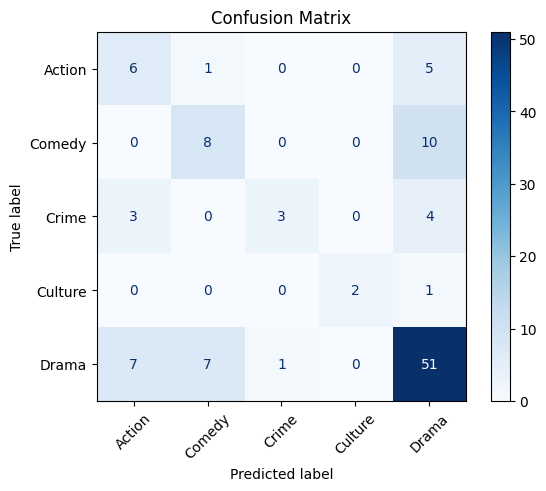

Predicted genre: Drama


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from hazm import Normalizer, word_tokenize, stopwords_list, Stemmer

file_path='dataset.xlsx'
df = pd.read_excel(file_path)
df = df[['Content_1', 'Genre']].dropna()

normalizer = Normalizer()
stop_words = set(stopwords_list())
stemmer = Stemmer()

def normalize_text(text):
    text = normalizer.normalize(text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

df['Content_1'] = df['Content_1'].astype(str).fillna('')

# Normalize the content using Hazm
df['Content_1'] = df['Content_1'].apply(normalize_text)

genre_mapping = {
    'Drama': ['Drama', 'Human Interest & Society', 'Family', 'Romance'],
    'Comedy': ['Comedy', 'Arts & Literature', 'Music', 'Animation'],
    'Action': ['Action', 'Adventure', 'Thriller', 'War'],
    'Crime': ['Crime', 'Mystery', 'Experimental', 'Horror'],
    'Culture': ['History', 'Culture & Traditions', 'Architecture & Urbanism', 'Portrait', 'Nature & Wildlife']
}

# Function to map genres to main genres
def map_genre(genre):
    for main_genre, similar_genres in genre_mapping.items():
        if genre in similar_genres:
            return main_genre
    return None

# Apply the mapping
df['Main_Genre'] = df['Genre'].apply(map_genre)

label_encoder = LabelEncoder()
df['Genre_encoded'] = label_encoder.fit_transform(df['Main_Genre'])

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Genre_encoded'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Genre_encoded'])

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(train_df[['Content_1']], train_df['Genre_encoded'])
train_df_resampled = pd.DataFrame({'Content_1': X_train_resampled['Content_1'], 'Genre_encoded': y_train_resampled})

tokenizer = AutoTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased')


class PersianMovieGenreDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)  # Ensure proper indexing
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = PersianMovieGenreDataset(train_df_resampled['Content_1'], train_df_resampled['Genre_encoded'], tokenizer)
val_dataset = PersianMovieGenreDataset(val_df['Content_1'], val_df['Genre_encoded'], tokenizer)
test_dataset = PersianMovieGenreDataset(test_df['Content_1'], test_df['Genre_encoded'], tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = AutoModelForSequenceClassification.from_pretrained('HooshvareLab/bert-fa-base-uncased', num_labels=len(label_encoder.classes_))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

trainer.train()

results = trainer.evaluate(test_dataset)
print(results)

model.save_pretrained('./parsbert_movie_genre_classifier')
tokenizer.save_pretrained('./parsbert_movie_genre_classifier')

predictions = trainer.predict(test_dataset)
y_true = test_df['Genre_encoded'].to_numpy()
y_pred = np.argmax(predictions.predictions, axis=1)

accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'F1 Score (Macro): {f1_macro}')
print(f'F1 Score (Micro): {f1_micro}')
print(f'Precision (Macro): {precision}')
print(f'Recall (Macro): {recall}')
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

def predict_genre(summary, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(summary, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        logits = model(inputs['input_ids'], attention_mask=inputs['attention_mask']).logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

# Example usage

summary = "سالار از طریق چوب بری قاچاق امرار معاش می کند. او یک بار هنگام قطع درخت، دستگیر، اره موتوری اش ضبط و روانه زندان می شود تا دوران محکومیت یک ساله اش را سپری کند. باجی همسر، جلال پسر، ماجان دختر - اعضای خانواده سالار - در غیاب او باید هزینه اره را به صاحب آن میرزا آقا بپردازند. ضمن اینکه ، قبل از واقعه اخیر قرار بوده تا ماجان با لطیف، سرباز اهری پاسگاه روستا ازدواج کند اما بعد از دستگیری سالار، چون باجی، لطیف را هنگام دستگیری شوهرش دیده است، پس در مورد ازدواج لطیف و ماجان تغییر عقیده می دهد. اما لطیف با پیگیری مستمر سعی می کند تا باجی را متقاعد به بی گناهی خود در دستگیری سالار و ازدواج خود با ماجان قانعش کند. جلال که رفتار نامناسب میرزا آقا را با مادرش به خاطر اره ضبط شده، می بیند، با او که رئیس قاچاقچیان چوب جنگل است توافق می کند تا درازای جبران خسارت وی، هر روزه برای فرج و عطا - قاچاقچیان چوب - اره را به میان جنگل ببرد. تحرکات پنهانی و غیبت های مستمر جلال، موجب حساسیت و نگرانی خانواده اش می شود. وقتی ماجان این نگرانی را با لطیف در میان می گذارد، او به تعقیب جلال در یک صبح زود می پردازد، اما لو میرود و توسط قاچاقچیان گرفتار و مورد ضرب و شتم قرار گرفته و جانش را ازدست میدهد. جلال، که در جریان این حادثه به بی گناهی لطیف و خیانت فرج آگاه شده می گریزد. فرج که دریافته او شاهد واقعه بوده، به تعقیبش می پردازد اما او را نمی یابد. باجی و ماجان که از ماوقع آگاه شده اند در جستجوری جلال برمی آیند و او را در درمانگاه روستا با چهره ای سخت پریشان و در هم می یابند، این زمانی است که سالار از زندان آزاد شده و به روستا بازگشته است. او به محض ورود به روستا سراغ لطیف را می گیرد."
predicted_genre = predict_genre(summary, model, tokenizer, torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Predicted genre: {predicted_genre}")

### BERT Model for Persian Movie Genre Classification

1. **Data Preparation:**
   - **Loading and Preprocessing the Dataset:**
     - The dataset is loaded from an Excel file (`dataset.xlsx`), focusing on the `Content_1` (movie summaries) and `Genre` columns, with missing values dropped.
   - **Text Normalization:**
     - Persian text is normalized using the `hazm` library, which includes removing stopwords and stemming.
   - **Genre Mapping:**
     - Genres are mapped to main genres (Drama, Comedy, Action, Crime, Culture) using a predefined dictionary. Rows with unmapped genres are excluded.

2. **Label Encoding:**
   - The main genres are converted to numerical labels using `LabelEncoder`.

3. **Train, Validation, and Test Split:**
   - The dataset is split into training (80%), validation (10%), and test (10%) sets, stratified by genre to maintain class balance.

4. **Balancing the Dataset:**
   - The training set is balanced using RandomOverSampler to handle class imbalance, creating a resampled training set.

5. **Tokenization:**
   - Summaries are tokenized using a Persian BERT tokenizer (`HooshvareLab/bert-fa-base-uncased`) to create input IDs and attention masks for the BERT model.

6. **Dataset and DataLoader:**
   - A custom `Dataset` class (`PersianMovieGenreDataset`) is defined to handle the tokenized inputs and labels, enabling efficient data loading with `DataLoader`.

### Model Definition

7. **Custom BERT Model:**
   - The `AutoModelForSequenceClassification` from Hugging Face is used, initialized with the number of genres as output labels.
   - The model is transferred to GPU if available.

### Model Training

8. **Training Arguments:**
   - Training is set up with `TrainingArguments`, specifying parameters like batch size, number of epochs, learning rate, weight decay, and evaluation strategy.
   - A `Trainer` is instantiated with the model, training arguments, datasets, tokenizer, and a custom metrics function for computing accuracy.

9. **Training and Evaluation:**
   - The model is trained for 3 epochs, with evaluation at each epoch to save the best model based on validation accuracy.
   - After training, the model is evaluated on the test set, with results printed and the model saved for future use.

### Model Evaluation

10. **Metrics Calculation:**
    - Predictions on the test set are used to compute accuracy, F1 score (macro and micro), precision, recall, and a confusion matrix.
    - The confusion matrix is plotted to visualize the model's performance across different classes.

### Inference Function

11. **predict_genre Function:**
    - A function to predict the genre of a given summary using the trained model. It tokenizes the input, processes it through the model, and returns the predicted genre.

### Example Usage

12. **Example Prediction:**
    - An example movie summary is provided, and the `predict_genre` function is used to predict its genre, demonstrating the model's inference capability.
